# Applied Deep Learning COMS4995 FS22 | Custom Course Project

#### Deep Learning for Finance: Using Stock Market News and Daily Close Values to Predict Next-Day Increase or Decrease

Erin Josephine (Josie) Donnelly | ejd2170


## I. Introduction

When imagining the applications of machine learning in the finance domain, many examples of tried-and-true methods come to mind—the nature of stock data lends itself nicely to time series forecasting, financial data in tabular form cooporates well with traditional regression and tree-based models, and text such as news articles can be used for semantic analysis. The multiple mediums of finance-realted data available inspired the idea to combine these approaches in a multi-phase model are compare it to the predictive performance of using just one medium.

Using Yahoo Finance data, two inputs—news articles and stock data—can be processed with their own LSTM sub-models, the outputs concatenated, and the result processed further with Dense layers to obtain a final prediction answering the question, "*Will the stock's close value increase or decrease the following day?*"


## II. Objectives

The ultimate objective of this project is to develop a deep learning model that takes both text from news articles and stock time series data as input to predict whether the following stock close value will be higher or lower than the previous day. This is posed as a binary classification problem for tangible interpretability and metrics in an otherwise relatively complicated problem. It also acts as a compromise between the change in stock value from day to day and the binary "positive" or "negative" labels used in typical semantic analysis.

When defining this project, I set the following levels of goals for myself:

1) **Minimal goal**: Explore DNNs, RNNs, and LSTM approaches to predict decisions for one stock.

2) **Expected goal**: Extend the minimal goal by including text input from news sources, and develop a model to predict decisions for multiple stocks.

3) **Stretch goal**: Extend the expected goal by implementing scraping to obtain more diverse and more current text sources for stronger sentiment analysis.

I am pleased to say that I was able to fulfill the third version **stretch goal** of the project, including two methods of scraping to get the most complete news data from Yahoo Finance. For brevity, only this final version is included in this notebook, for it demonstrates many of the processes used in the other two versions as well. The details and outcomes are discussed below.
   

## III. Preparatory work: EDA baseline models, and model selection

Exploratory data analysis and visualization, data scraping and processing, and baseline modeling were completed in separate notebooks. All final material is available in this project's GitHub repository (https://github.com/ejosied/dl-for-finance).

The baseline models were modified from TensorFlow's time series forecasting tutorial (https://www.tensorflow.org/tutorials/structured_data/time_series). Using different dense, convolutional, and recurrent neural networks, we achieve models that reasonably predicts one or more future market values. Turning this into an increase-or-decrease binary classification problem allows the results to be compared to the results in this notebook. However, there are limitations with this baseline method:

- While some stocks may exhibit seasonality due to factors like season, holidays, and tax schedules, they are not always consistent between stocks and time frames. Seasonal patterns may conflict or interfere with predictions depending on model structure, but most often, there is no significant seasonality for the model to learn.

- Time serires forecasting considers each stock individually. A strength of the approach in this notebook is that the stock itself is not important during training or inference, allowing us to increase the size of the dataset by considering diverse stocks and generalize to make predictions for stocks outside of the training set.

Thus we shift our focus from sole time series models to the crux of our problem: combining these strategies with language models.

Model selection and hyperparameter tuning was one in a couple ways: intuitive experimentation, and analyses of single-input models restricted to only news or stock data. This is done easily by the choice of hyperparameters `USE_NEWS_MODEL` and `USE_STOCKS_MODEL`, which simply decides which layers are added to the model and which inputs from the `tf.Dataset`s are input into the model. This experimentation yields the following observations, among others:

- `USE_NEWS_MODEL = True` and `USE_STOCKS_MODEL = False`: The model learns the training data well after a sufficient number of epochs to the point of overfitting. The test accuracy oscillates below 50%. This is likely due to the fact that news examples do not come with semantic labels, but rather implied labels based on next-day stock behavior. This is discusseed more in Section VI.

- `USE_NEWS_MODEL = False` and `USE_STOCKS_MODEL = True`: Efficient models (with fewer than three LSTM layers and fewer than 20 epochs) struggle to learn even the training data, whose accuracy barely exceeds 50%. Meanwhile, the test accuracy reaches higher to 60%. This is probably because LSTM models perform well when there is a seasonal component to the time series, which is not prevalent in the stock data as discussed above.

- `USE_NEWS_MODEL = True` and `USE_STOCKS_MODEL = True`: We achieve a compromise between the above two outcomes—the model learns the training well with expected (but not overwhelmingly blatant) overfitting, and the test accuracy remains above 50% and nears 55%. This is achieved with fewer than 1.5 million parameters. This is a good place for the model to be at the end of this project, for it shows that the potential for a combined-input approach to exceed predictive power of a single-input model with the right data acquisition and processing, model selection, and hyperparameter tuning.


## IV. Import libraries

Import necessary libraries including Yahoo Finance, pandas, numpy, and TensorFlow. Note that more TensorFlow layer were imported than were used for ease of experimentation in model selection.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
import re
import os

from collections import Counter
from nltk.corpus import stopwords

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, RNN, Bidirectional, Dense, Embedding, TextVectorization, Flatten, Input, Dropout
from tensorflow.keras.utils import plot_model


2022-12-19 11:55:21.594564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
date_today = datetime.now().date()
print(f'Last updated {date_today}')


Last updated 2022-12-19


## V. Define hyperparameters

Define all hyperparameters at the start of the process for organization purposes. Hyperparameter tuning was done manually during this project. Note that a couple hyperparameters—`MAX_SEQ_LEN` and `VOCAB_SIZE` for the TextVectorization layer—are decided later using more sophisticated approaches.

Most hyperparameters have names that are descriptive enough to indicate their use; more obscure names have explanations in the comments below. A few significant choices are expalained here:

- `N_DAYS_IN_TEST`: The past week of stock values are used in the test set to ensure that around 20% of examples contributie to the test set after filtering by `UNIQUE_URL` and `BALANCE_DATASET`.

- `UNIQUE_URL` is True for the best chance of ensuring that each news article is only associated with one stock. Otherwise, we risk the same article being associated with a different "semantic" label (0 or 1) for different stocks or days. Notice that the most recent article is kept which the earlier ones are discarded to ensure earlier versions with misinformation is corrected by edits and updates.

- `ONE_PER_DAY` is False because it resticts the size of the dataset to the point that generalizable patterns are not learned. It also introduces bias into the data, for the model cannot see the most complete picture.

- `BALANCE_DATASET` is True to ensure that both the train and test data are split 50-50% with respect to the label. The training data usually achieves this balance on its own, for observations over several months tend to even out, but the most recent data used in the test set is often skewed significantly in one way or the other. At the time of final model development, there were significantly more decreasing (0) stocks than there were increasing (1) in the most recent week of data.

- `USE_NEWS_MODEL` and `USE_STOCKS_MODEL` are both True to achieve the compromise discussed in Section III. The balance of the two inputs is controlled by the choice of `NEWS_UNITS` and `STOCK_UNITS`: more values in the concatenated layer are contributed by the stock model than the news model. This is done to mimic real-world behavior: reading the news may support your prediction, but ultimately the stock values determine stock performance. Also note that for this data, the model performed best with only one recurrent layer each for news and stocks, each using `return_sequences = False` before being concatenated for the final model.

- `N_EPOCHS` is limited to 15 to avoid exacerbated overfitting to the training data.

All comments, assumptions, and observations in this notebook are relevant to the model described by the hyperparameters chosen below. Other details about the use of hyperparameters are described in comments throughout the notebook.


In [3]:
N_DAYS_IN_TEST = 7
N_STOCK_UNITS = 2     # number of STOCK_UNITS of stock data to load in
STOCK_UNIT = 'mo'     # years = 'y', months = 'mo'
N_SEQ_WEEKS = 4     # number of weeks of stock data that will be included in each example's sequence
N_TIMESTEPS = 3

UNIQUE_URL = True     # ensure each URL appears only once and associated with only one stock
ONE_PER_DAY = False     # consider only one article per stock per day
MIN_STOCK_FREQ = None     # the minimum number of articles associated with a stock for it to be considered; non-zero integer or None (same behavior as 0)

REMOVE_STOPWORDS = True
BALANCE_DATASET = True     # ensure the train and tests sets are both split 50-50% with respect to labels

USE_NEWS_MODEL = True
USE_STOCKS_MODEL = True

NEWS_EMBEDDING_DIM = 128
NEWS_USE_BIDIRECTIONAL = True
NEWS_UNITS = [16]
NEWS_DROPOUT = 0.2

STOCK_UNITS = [64]
STOCK_DROPOUT = 0.1

DENSE_UNITS = [32, 32, 1]

LR = 1e-4

BUFFER_SIZE = 1000
BATCH_SIZE = 32

N_EPOCHS = 15

assert USE_NEWS_MODEL or USE_STOCKS_MODEL, "Please indicate at least one of news or stock model"

# hyperparameters chosen using algorithms later:
# MAX_SEQ_LEN
# VOCAB_SIZE


In [4]:
# set the global seed for relative reproducibility
tf.random.set_seed(3)
# as a tradeoff, we sacrifice full reproducibility to gain back some time efficiency using statements like the one below
# tf.config.experimental.enable_op_determinism()


## VI. Read scraped Yahoo Finance news

Read in the dataframe containing all text data obtained from Yahoo Finance News. All data was obtained through one of the following two scraping strategies employing BeautifulSoup:

1) **Yahoo Finance via API**: Each day, eight or fewer news articles are indicated for each stock. A daily script attempts to scrape the content from each URL, but only a handful of articles give the necessary permissions. This approach is automated, but does not yield many examples.

2) **Yahoo Finance via HTML**: To obtain more news examples over a larger time window, the Yahoo Finance Stock Market News can be used to search a specific stock and—after the dynamic page is fully loaded—the full HTML code available upon inspection can be copied to a text file. URLs can then be pulled from the file using simple string processing, and these URLs can be scraped using an automated script. As my only scraping experience has been from this project, I am curious to learn how to handle dynamic pages and automate this process fully.

A variety of stocks are considered. Preliminary proof-of-concept models were trained on stocks in the technology sector—Apple (`'AAPL'`), Microsoft (`'MSFT'`), and Nvidia (`'NVDA'`) to name a few—and a few composite indexes like S&P 500 (`'^GSPC'`), chosen for the high volume of data and expectation of strongly-worded, opinionated articles. The dataset was expanded over time to include healthcare, automobile and airline transportation, oil, steel, energy, entertainment, retail, and food companies for a total of 160 stocks.

Note that there are a few limitations and assumptions used regarding this data:

- Embracing the familiar speed-accuracy tradeoff, the news examples do not have human- or model-identified semantic labels associated with them. Instead, the stock outcome—whether it increased or decreased the next day—is considered a "*free label*" of whether the article speaks favorably of the stock or not. If labeled data was available, we could have used the semantics of the article as input instead of the text itself, but that would remove much of the interesting deep learning concepts used in this project.

- Some articles discuss many stocks, and may not have consistent positive or negative tone throughout. Since semantic analysis in not directly implemented or utilized in this model, it is assumed that the text will be able to inform the model's prediction in some indirect way.

- Identical or slightly modified news articles may be shared between stocks, published on different dates under different URLs, etc. Dropping duplicates grouped by stock and URL corrects for some of this, ensuring that only the most up-to-date news article is used. But, because articles attributed to multiple stocks are likely published at the same time under the same URL, they will either be filtered out or ensured to be in the same set: train or test. This minimizes the concern of test data leakage, more of which will be discussed in the comments. Setting `UNIQUE_URL = True` gives the best chance at avoiding this problem.

Ultimately, while there is more than enough stock data to use LSTM in stock-only models, there is insufficient news data to train a model with excellent predictive results on the test set. As in similar scenarios throughout this Deep Learning course, we embrace the methods and do the best work we can in spite of the limited data. After all, the goal of the project is not to develop a new state-of-the-art stock predictor, but to **develop an innovative approach that answers an interesting question and looks beyond off-the-shelf solutions**.


In [5]:
# download and filter news data according to hyperparameters
verbose = 0
news_dir = '../data'
news_folders = ['scraped_news_from_api', 'scraped_news_from_html']
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()
news_df = pd.DataFrame()
for folder in news_folders:
    for news_file in os.listdir(os.path.join(news_dir, folder)):
        if not news_file.endswith('.csv'):
            continue
        tmp_df = pd.read_csv(os.path.join(news_dir, folder, news_file), parse_dates=['publish_date'], date_parser=date_parser)
        if verbose > 0:
            print(f'{news_file}\t({tmp_df.shape[0]})')
        news_df = pd.concat([news_df, tmp_df])
    
news_df = news_df.drop(columns=['scrape_date', 'related_tickers']).sort_values('publish_date').rename(columns={'index': 'stock'})
if UNIQUE_URL:
    news_df = news_df.drop_duplicates(subset=['url'], keep='last').reset_index(drop=True)
else:
    news_df = news_df.drop_duplicates(subset=['stock', 'url'], keep='last').reset_index(drop=True)
    
if MIN_STOCK_FREQ is not None:
    stock_counter = Counter(news_df['stock'])
    keep_stocks = [stock for stock,freq in stock_counter.items() if freq >= MIN_STOCK_FREQ]
    news_df = news_df[news_df['stock'].isin(keep_stocks)].reset_index(drop=True)


print(f'Number of articles: {news_df.shape[0]}')
print(f'Number of stocks: {len(np.unique(news_df["stock"]))}')
print(f'Date range: {min(news_df["publish_date"]).date()} to {max(news_df["publish_date"]).date()}')

# uncomment to experiment with having only one article associated with each stock per day
if ONE_PER_DAY:
    news_df = news_df.drop_duplicates(subset=['stock', 'publish_date'], keep='last').reset_index(drop=True)

news_df


Number of articles: 5487
Number of stocks: 160
Date range: 2022-09-02 to 2022-12-19


,stock,url,news,headlines,raw_publish_date,publish_date
0,SPOT,http://www.finance.yahoo.com/news/legendary-mu...,"Mega-hit song ""Gangnam Style"" by K-pop singer ...","['Yahoo Finance', 'Legendary music producer: ‘...","September 2, 2022, 10:32 AM",2022-09-02
1,HMC,http://www.finance.yahoo.com/news/supply-chain...,Supply chain issues have hampered the auto ind...,"['Yahoo Finance', 'Supply chains still hamperi...","October 6, 2022, 2:46 AM",2022-10-06
2,NIO,http://www.finance.yahoo.com/news/14-best-most...,"In this article, we will discuss the 14 best m...","['Yahoo Finance', '14 Best Most Active Stocks ...","October 12, 2022, 7:41 AM",2022-10-12
3,LUV,http://www.finance.yahoo.com/news/airline-stoc...,Airline stocks are so cheap from a valuation p...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
4,FOX,http://www.finance.yahoo.com/news/rupert-murdo...,Rupert Murdoch is reportedly considering a rec...,"['Yahoo Finance', 'Rupert Murdoch considers re...","October 14, 2022, 2:44 PM",2022-10-14
...,...,...,...,...,...,...
5482,ADBE,https://finance.yahoo.com/news/company-news-de...,Shares of Adobe Inc. ADBE surged 3% after the ...,"['Yahoo Finance', 'Company News for Dec 19, 20...","December 19, 2022, 6:24 AM",2022-12-19
5483,BYDDY,https://finance.yahoo.com/news/most-dramatic-s...,(Bloomberg) -- From a little-known manufacturi...,"['Yahoo Finance', 'Most Dramatic Stock Moves o...","December 19, 2022, 7:23 AM",2022-12-19
5484,INTC,https://finance.yahoo.com/news/intels-german-a...,Intel Corp (NASDAQ: INTC) retreated from its i...,"['Yahoo Finance', ""Intel's German Ambitions Hi...","December 19, 2022, 5:03 AM",2022-12-19
5485,AZN,https://finance.yahoo.com/news/astrazeneca-dru...,AstraZeneca Plc (NASDAQ: AZN) announced toplin...,"['Yahoo Finance', 'AstraZeneca Drug Imfinzi Fa...","December 19, 2022, 2:48 AM",2022-12-19


In [6]:
# function to standardize text and remove digits, punctuation, stop words
def std_txt(txt, remove_stopwords=True):
    sw = []
    if remove_stopwords:
        sw = stopwords.words('english')
        
    txt = txt.strip().lower()
    txt = re.sub(r'[^\w\s]', ' ', txt)
    txt = re.sub(f'[0-9]', '', txt)
    txt = [word for word in txt.split() if word not in sw]
    txt = ' '.join(txt)
    
    return txt


In [7]:
# standardize and remove stopwords from all news examples
for i in range(news_df.shape[0]):
    news_df.loc[i,'news'] = std_txt(news_df.loc[i,'news'], remove_stopwords=REMOVE_STOPWORDS)
news_df.head()


,stock,url,news,headlines,raw_publish_date,publish_date
0,SPOT,http://www.finance.yahoo.com/news/legendary-mu...,mega hit song gangnam style k pop singer psy i...,"['Yahoo Finance', 'Legendary music producer: ‘...","September 2, 2022, 10:32 AM",2022-09-02
1,HMC,http://www.finance.yahoo.com/news/supply-chain...,supply chain issues hampered auto industry sin...,"['Yahoo Finance', 'Supply chains still hamperi...","October 6, 2022, 2:46 AM",2022-10-06
2,NIO,http://www.finance.yahoo.com/news/14-best-most...,article discuss best active stocks buy want ex...,"['Yahoo Finance', '14 Best Most Active Stocks ...","October 12, 2022, 7:41 AM",2022-10-12
3,LUV,http://www.finance.yahoo.com/news/airline-stoc...,airline stocks cheap valuation perspective oug...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
4,FOX,http://www.finance.yahoo.com/news/rupert-murdo...,rupert murdoch reportedly considering recombin...,"['Yahoo Finance', 'Rupert Murdoch considers re...","October 14, 2022, 2:44 PM",2022-10-14


## VII. Download stock data

Obtain the stock data over the past couple months (determined by `N_STOCK_UNITS` and `STOCK_UNIT`), for most scraped articles were recently published. Stock data contains six values each day: Adjusted Close, Close, High, Low, Open, and Volume. For consistency, we only consider the close values, which are standardized by stock.

This data will be matched with the news data and missing values will be handled in Section VIII.

In [8]:
stocks = list(np.unique(news_df['stock']))
print(f'Downloading stock data for the past {N_STOCK_UNITS}{STOCK_UNIT}...')
history_df = yf.download(stocks, period=f'{N_STOCK_UNITS}{STOCK_UNIT}')
print(f'Shape: {history_df.shape}')
print(f'First level columns: {", ".join(np.unique([c[0] for c in history_df.columns]))}')
history_df.head()


[*********************100%***********************]  160 of 160 completed
Shape: (43, 960)
First level columns: Adj Close, Close, High, Low, Open, Volume


Adj Close                                                \
                 AAL        AAPL        ACI        ADBE      ADDYY   
Date                                                                 
2022-10-19     13.99  143.621750  20.304348  299.829987  56.410000   
2022-10-20     13.46  143.152527  20.528292  302.380005  53.939999   
2022-10-21     13.71  147.026108  20.955757  306.369995  51.750000   
2022-10-24     14.10  149.202484  20.667467  316.220001  51.360001   
2022-10-25     14.29  152.087708  20.577997  323.790009  50.099998   

                                                                     ...  \
                  AGCO       AJRD        ALK        AMD        AMZN  ...   
Date                                                                 ...   
2022-10-19  111.200844  43.459999  41.849998  57.230000  115.070000  ...   
2022-10-20  110.322495  43.549999  39.880001  57.770000  115.250000  ...   
2022-10-21  115.492767  44.880001  41.009998  58.820000  119.320000  ...   
2022-10-24  115.472809  45.330002  42.580002  58.700001  119.820000  ...   
2022-10-25  118.477150  47.490002  43.410000  61.470001  120.599998  ...   

              Volume                                                         \
                 WMG      WMT     WRBY         X       XOM      XPEV   ZEUS   
Date                                                                          
2022-10-19   1523900  3779800  1344600   6812800  20921700  34163300  25800   
2022-10-20    743700  4251600  1065200  10323100  17649000  31671400  44400   
2022-10-21    703300  6044900   797600  13706800  22814100  21934400  24800   
2022-10-24  10027200  6268900   798900   8990500  17024200  60411400  18800   
2022-10-25   2518100  5017100   938000   9809200  15719800  33409400  21500   

                                             
                 ZM       ^GSPC       ^IXIC  
Date                                         
2022-10-19  1955800  4223800000  4955090000  
2022-10-20  4156900  4496620000  4628010000  
2022-10-21  3312100  5078020000  4706440000  
2022-10-24  2731600  4747930000  4808710000  
2022-10-25  2992300  4843120000  5141760000  

[5 rows x 960 columns]

In [9]:
# standardize by stock (close data only)
close_df = history_df['Close']
ss = StandardScaler()
close_df[close_df.columns] = ss.fit_transform(close_df[close_df.columns])

close_df.head()


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,AAL,AAPL,ACI,ADBE,ADDYY,AGCO,AJRD,ALK,AMD,AMZN,...,WMG,WMT,WRBY,X,XOM,XPEV,ZEUS,ZM,^GSPC,^IXIC
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-19,0.048876,-0.281606,4.319958,-1.562653,-0.560142,-2.149581,-2.296919,-1.817769,-1.599582,1.883250,...,-1.596626,-2.109782,-1.316256,-1.655328,-1.547024,-0.542140,-1.923046,-0.260908,-1.979467,-1.044900
2022-10-20,-1.050279,-0.369972,4.531042,-1.403474,-0.926839,-2.282455,-2.268060,-2.960160,-1.516721,1.901949,...,-1.546511,-2.049499,-1.834889,-1.448532,-1.507019,-0.376894,-1.711025,0.441238,-2.255516,-1.267583
2022-10-21,-0.531810,0.359523,0.013827,-1.154408,-1.251965,-1.500316,-1.841591,-2.304880,-1.355603,2.324752,...,-1.588273,-1.554456,-1.503304,-0.782650,-0.955511,-0.260610,-1.350588,0.638536,-1.438360,-0.437209
2022-10-24,0.277003,0.769393,-0.190221,-0.539543,-1.309865,-1.503336,-1.697297,-1.394443,-1.374016,2.376694,...,-1.042576,-1.077681,-1.120706,-0.869504,-0.744053,-0.854271,-1.361189,0.566967,-1.019399,-0.122223
2022-10-25,0.671039,1.312753,-0.253547,-0.067002,-1.496924,-1.048851,-1.004687,-0.913132,-0.948972,2.457722,...,-0.619381,-0.957117,0.010084,-0.873640,-0.949797,-0.376894,-1.292282,1.240097,-0.439018,0.713677


In [10]:
# remove stocks with only NaN values from consideration in both the stock and news datasets
for stock in stocks:
    if close_df.isna().sum()[stock] == close_df.shape[0]:
        print(f'Removing {stock}')
        close_df = close_df.drop(columns=stock)
        news_df = news_df[news_df['stock']!=stock].reset_index(drop=True)
        
# check that the results make sense
stocks = list(np.unique(news_df['stock']))
print(f'Number of stocks: {len(stocks)}')
        

Number of stocks: 160


## VIII. Merge stock data with news

For each article in the `news_df` dataframe, use the stock and publish date to obtain the standardized stock close data for the `N_SEQ_WEEKS` prior to the article. These times are adjusted for weekends when the stocks remain closed, coercing the date to the nearest Monday or Friday. If days are missing due to public holidays or otherwise, mean imputation for the time window considered is used to ensure that all stock sequence have the same number of values. With weekends excluded, midding values imputed, and the time frame restricted to weeks, each stock sequence is guaranteed to have `N_SEQ_WEEKS * 5` values.

This loop also takes care of determining the labels. The close value on the last day of the stock sequence is compared to the close value of the soonest close value available after the publish date, again adjusting for weekends and missing values. If the close value decreases, assign the label 0; if it increases or remains the same (chosen arbitrarily), assign the label 1. The label -1 indicates that the stock sequences is not fully contained in the time frame indicated by `N_STOCK_UNITS` (recommended years or months); these examples are discarded.

With more data available over a longer period of time, it would be prudent to adjust the label to predict a more long-term stock change, perhaps determining whether the stock increased on decreased *on average* from the previous week to the next. For the purpose of this project, we adhere to day-to-day comparison; it optimizes the limited available data, and answers the proposed question directly.

At the end of this section, we balance the train and test sets with the repect to the label as indicated by `BALANCE_DATASET = True`. This is necessary because there are a relatively even number of increasing and decreasing stocks on average over longer periods of time, but the data is typically skewed one way of the other when looking at a smaller time windows like a matter of days for the test set.


In [11]:
# use history to give a "label" to the news articles:
# 1 if close values increase (or stayed the same)
# 0 if close value decreased

targets = []
stock_seqs = []

earliest_date, latest_date = min(close_df.index).date(), max(close_df.index).date()
print(f'Earliest: {earliest_date}')
print(f'Latest: {latest_date}\n')

for i in range(news_df.shape[0]):
    
    seq = []
    stock = news_df.loc[i, 'stock']
    d1 = news_df.loc[i, 'publish_date']
    d2 = d1 + timedelta(days=1)
    
    cont = False
    
    day1_close = None
    while day1_close is None:
        try:
            day1_close = close_df.loc[d1, stock]
        except KeyError:
            d1 -= timedelta(days=1)
            if d1.date() < earliest_date:
                targets.append(-1)     # preceeds window of consideration
                stock_seqs.append(np.array([]))
                cont = True
                break
                
    if cont:
        continue
    
    day2_close = None
    while day2_close is None:
        try:
            day2_close = close_df.loc[d2, stock]
        except KeyError:
            d2 += timedelta(days=1)
            if d2.date() > latest_date:
                targets.append(-1)     # future data not yet obtained
                stock_seqs.append(np.array([]))
                cont = True
                break
                
    if cont:
        continue 
        
    # ensure at least N_SEQ_WEEKS of data exists
    d = d1 - timedelta(weeks=N_SEQ_WEEKS)
    if d < earliest_date:
        targets.append(-1)
        stock_seqs.append(np.array([]))
        continue  

    # obtain the label
    if day1_close - day2_close > 0:
        # stock decreased
        targets.append(0)
    else:
        # stock increased or remained the same (chosen arbitrarily)
        targets.append(1)
    
    # obtain the N_SEQ_WEEKS * 5 stock values for the two weeks prior to day 1 (skip weekends)
    while d < d1:
        if d.weekday() in [5,6]:
            d += timedelta(days=1)
            continue
        try:
            seq.append(close_df.loc[d, stock])
        except:
            seq.append(np.nan)
        d += timedelta(days=1)
        
    seq_mean = np.mean(pd.Series(seq).fillna(0).tolist())
    seq = pd.Series(seq).fillna(seq_mean).tolist()
    assert len(seq) == N_SEQ_WEEKS*5
    stock_seqs.append(np.array(seq))
        
counter = Counter(targets)
print(f'Number of decreasing (0) examples: {counter[0]}')
print(f'Number of increasing (1) examples: {counter[1]}')
print(f'Number of discarded examples (outside of time window): {counter[-1]}')


Earliest: 2022-10-19
Latest: 2022-12-19

Number of decreasing (0) examples: 2836
Number of increasing (1) examples: 2338
Number of discarded examples (outside of time window): 313


/var/folders/9p/2w26l_q932bbph2rfc83837c0000gn/T/ipykernel_23797/2551476748.py:53: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if d < earliest_date:


In [12]:
news_df['stock_seq'] = stock_seqs
news_df['target'] = targets
news_df = news_df[news_df['target'] >= 0].reset_index(drop=True)
print(f'Shape: {news_df.shape}')
news_df.head()


Shape: (5174, 8)


,stock,url,news,headlines,raw_publish_date,publish_date,stock_seq,target
0,PTON,http://www.finance.yahoo.com/news/1-peloton-se...,adds details sales strategy background shares ...,"['Yahoo Finance', 'UPDATE 1-Peloton to sell ex...","November 16, 2022, 4:22 AM",2022-11-16,"[-1.6041515115761042, -1.5922360778775893, -1....",0
1,PTON,http://www.finance.yahoo.com/news/peloton-awar...,northampton accesswire november friday septemb...,"['Yahoo Finance', ""Peloton Awarded With WHEDco...","November 16, 2022, 10:25 AM",2022-11-16,"[-1.6041515115761042, -1.5922360778775893, -1....",0
2,BAC,http://www.finance.yahoo.com/news/why-bank-ame...,month gone since last earnings report bank ame...,"['Yahoo Finance', 'Why Is Bank of America (BAC...","November 16, 2022, 8:30 AM",2022-11-16,"[-0.8017840861354423, -0.9097909088190281, -0....",0
3,BAC,http://www.finance.yahoo.com/news/5-9-bank-ame...,looking bank america corporation nyse bac insi...,"['Yahoo Finance', ""5.9%of this Bank of America...","November 16, 2022, 4:01 AM",2022-11-16,"[-0.8017840861354423, -0.9097909088190281, -0....",0
4,VZ,http://www.finance.yahoo.com/news/traveling-ab...,verizon sourcing llcwhether traveling days mon...,"['Yahoo Finance', 'Traveling abroad this holid...","November 16, 2022, 6:57 AM",2022-11-16,"[-1.2390243682257864, -0.7294947875426028, -2....",1


In [13]:
# choose test set by choosing last few days of articles
test_news_df = news_df[news_df['publish_date'] >= pd.Timestamp(max(news_df['publish_date']).date() - timedelta(days=N_DAYS_IN_TEST))]
train_news_df = news_df.drop(test_news_df.index, axis=0).reset_index(drop=True)
test_news_df = test_news_df.reset_index(drop=True)

print(f'Number of train articles: {train_news_df.shape[0]}', end='  ')
train_count_1 = train_news_df[train_news_df["target"]==1].shape[0]
print(f'({train_count_1/train_news_df.shape[0]:.2f}% with label 1)')
print(f'Number of test articles: {test_news_df.shape[0]}', end='  ')
test_count_1 = test_news_df[test_news_df["target"]==1].shape[0]
print(f'({test_count_1/test_news_df.shape[0]:.2f}% with label 1)')
test_percent = test_news_df.shape[0]/news_df.shape[0]
print(f'Test percent: {test_percent:.2f}')

assert news_df.shape[0] == train_news_df.shape[0] + test_news_df.shape[0]


Number of train articles: 3694  (0.49% with label 1)
Number of test articles: 1480  (0.35% with label 1)
Test percent: 0.29


In [14]:
drop_from_train = True

overlap = np.intersect1d(train_news_df['url'], test_news_df['url'])
print(f'Number of urls in both train and test data: {len(overlap)}')
if len(overlap) > 0:
    if drop_from_train:
        print('\tDropping repeat url(s) from train set...')
        # remove urls in both train and test set from the train set
        for url in overlap:
            train_news_df = train_news_df[train_news_df['url'] != url]
        train_news_df = train_news_df.reset_index(drop=True)
    else:     # drop from test
        print('\tDropping repeat url(s) from test set...')
        # remove urls in both train and test set from the traim set
        for url in overlap:
            test_news_df = test_news_df[test_news_df['url'] != url]
        test_news_df = test_news_df.reset_index(drop=True)
        
    print(f'Number of train articles: {train_news_df.shape[0]}')
    print(f'Number of test articles: {test_news_df.shape[0]}')
    print(f'Test percent: {test_news_df.shape[0]/news_df.shape[0]:.2f}')


Number of urls in both train and test data: 0


In [15]:
# function to balance train and test sets by dropped earliest examples of majority class
def balance_df(df):
    count_1 = df['target'].sum()
    count_0 = df.shape[0] - count_1
    
    if count_0 == count_1:
        return df
        
    delete = 0
    if count_1 > count_0:
        delete = 1
    rows_to_drop = []
    for i in range(df.shape[0]):
        if df.loc[i,'target'] == delete:
            rows_to_drop.append(i)
        if len(rows_to_drop) == np.abs(count_0 - count_1):
            break
            
    df = df.drop(labels=rows_to_drop, axis=0).reset_index(drop=True)
    
    return df


In [16]:
# ensure train and test set are balanced in terms of the target
if BALANCE_DATASET:
    train_news_df = balance_df(train_news_df)
    test_news_df = balance_df(test_news_df)

    print('Train set')
    print(f'\tCount 0: {train_news_df["target"].sum()}', end='  ')
    print(f'\tCount 1: {train_news_df.shape[0]-train_news_df["target"].sum()}')

    print('\nTest set')
    print(f'\tCount 0: {test_news_df["target"].sum()}' ,end='  ')
    print(f'\tCount 1: {test_news_df.shape[0]-test_news_df["target"].sum()}')

    print(f'\nNumber of train articles: {train_news_df.shape[0]}')
    print(f'Number of test articles: {test_news_df.shape[0]}')
    test_percent = test_news_df.shape[0]/news_df.shape[0]
    print(f'Test percent: {test_percent:.2f}')


Train set
	Count 0: 1820  	Count 1: 1820

Test set
	Count 0: 518  	Count 1: 518

Number of train articles: 3640
Number of test articles: 1036
Test percent: 0.20


## IX. Analyze train and test sets

Check the train and test datasets to ensure everything looks right before proceedings. Checks like this revealed inbalance in the labels between training and testing data, skewing performance metrics and inspiring the `balance_df` function used above. From these checks, we can see the following:

- The train and test datasets are balanced with respect to the label.
- For the vast majority of stocks, most examples contribute to training with a few reserved for test. There are a few stocks that contribute more or less that average to the test set (some contributing no examples at all to one set or the other), but this is not an issue because the stocks themselves are not important to the model; rather, the language used for the implied semantic analysis is important.
- As is appropriate for the time series nature of the data, all test data is more recent that the train data, allowing us to condition the future on the past.

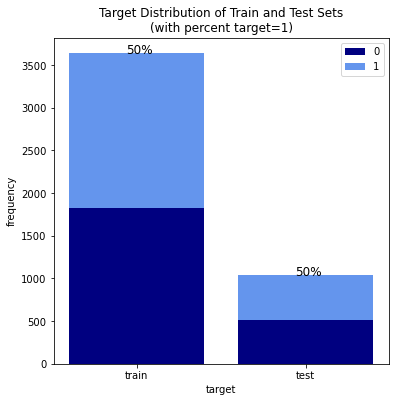

In [17]:
# display the frequency of targets included in the train and test sets
plt.figure(figsize=(6,6))

vals_0 = [train_news_df[train_news_df['target']==0].shape[0], test_news_df[test_news_df['target']==0].shape[0]]
vals_1 = [train_news_df[train_news_df['target']==1].shape[0], test_news_df[test_news_df['target']==1].shape[0]]

percents_1 = [vals_1[0]/(vals_0[0]+vals_1[0]), vals_1[1]/(vals_0[1]+vals_1[1])]
heights = [vals_0[0] + vals_1[0], vals_0[1] + vals_1[1]]

plt.bar(['train','test'], vals_0, label='0', color='navy')
plt.bar(['train','test'], vals_1, bottom=vals_0, label='1', color='cornflowerblue')
for i, p in enumerate(percents_1):
    plt.text(i-.06, heights[i], f'{p*100:.0f}%', fontsize='large')
    
plt.title('Target Distribution of Train and Test Sets\n(with percent target=1)')
plt.xlabel('target')
plt.ylabel('frequency')
plt.legend()

plt.show()
                    

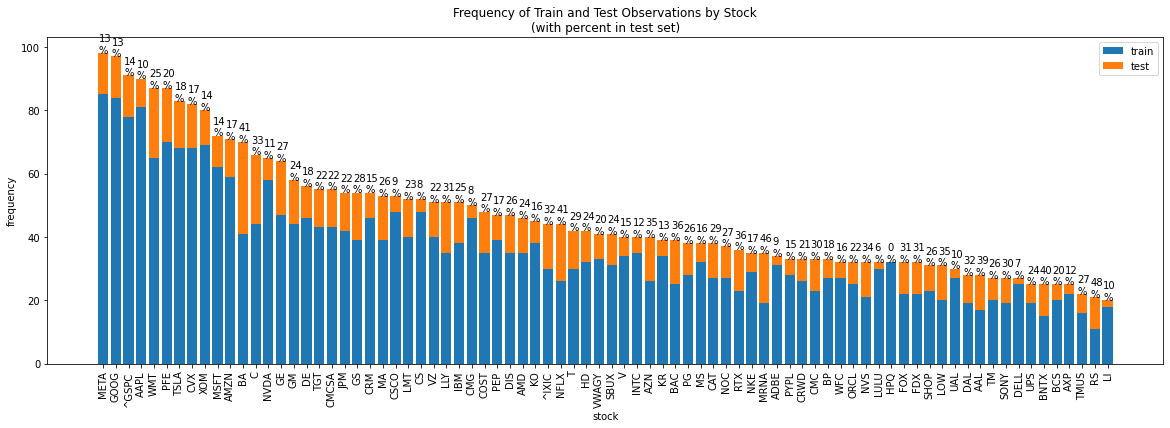

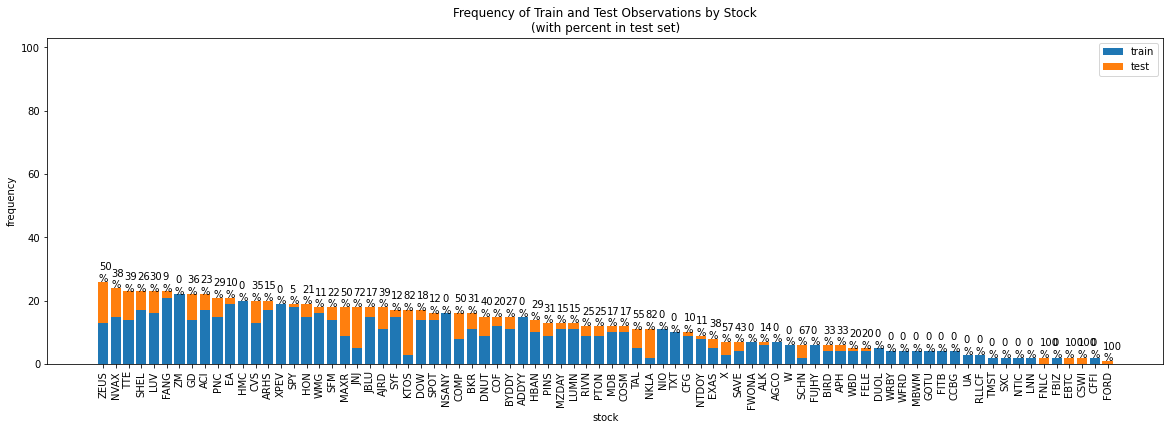

In [18]:
# display the stocks of targets included in the train and test sets
# use two plots: one for popular stocks, the other for rare stocks in this dataset
counter = Counter(news_df['stock'])
counter = sorted(counter.items(), key=lambda item: item[1], reverse=True)

pop_idx_df = news_df[news_df['stock'].isin([pair[0] for pair in counter[:len(counter)//2]])]
rare_idx_df = news_df[news_df['stock'].isin([pair[0] for pair in counter[len(counter)//2:]])]
ylim = None
for tmp_df in [pop_idx_df, rare_idx_df]:
    plt.figure(figsize=(20,6))
    stocks = np.unique(tmp_df['stock'])
    train_freqs = []
    test_freqs = []
    for stock in stocks:
        train_freqs.append(train_news_df[train_news_df['stock']==stock].shape[0])
        test_freqs.append(test_news_df[test_news_df['stock']==stock].shape[0])
    heights = [train_freqs[i] + test_freqs[i] for i in range(len(stocks))]

    freqs = [(stock, train_freq, test_freq) for _, stock, train_freq, test_freq in sorted(zip(heights, stocks, train_freqs, test_freqs), reverse=True)]
    heights = sorted(heights, reverse=True)

    percents_test = [f[2]/(f[1]+f[2]) for f in freqs]

    plt.bar([f[0] for f in freqs], [f[1] for f in freqs], label='train')
    plt.bar([f[0] for f in freqs], [f[2] for f in freqs], bottom=[f[1] for f in freqs], label='test')
    for i, p in enumerate(percents_test):
        plt.text(i-.35, heights[i], f'{p*100:.0f}\n%')

    plt.title('Frequency of Train and Test Observations by Stock\n(with percent in test set)')
    plt.xlabel('stock')
    plt.xticks(rotation=90)
    plt.ylabel('frequency')
    if ylim is None:
        ylim = max(heights) + 5
    plt.ylim(top=ylim)
    plt.legend()

    plt.show()


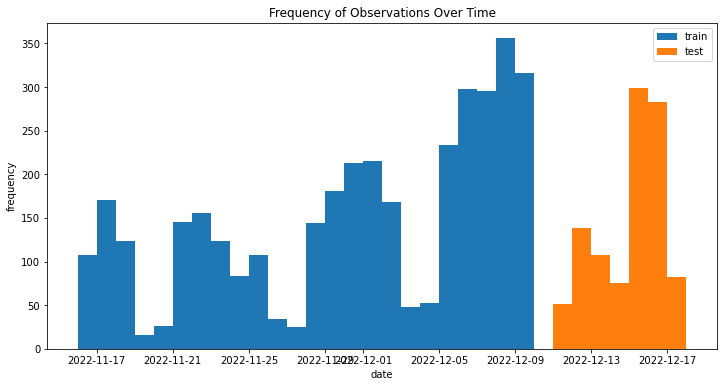

In [19]:
# show frequency historgram by date
min_train_date = min(train_news_df['publish_date']).date()
max_train_date = max(train_news_df['publish_date']).date()

min_test_date = min(test_news_df['publish_date']).date()
max_test_date = max(test_news_df['publish_date']).date()

plt.figure(figsize=(12,6))
plt.hist(train_news_df['publish_date'], bins=(max_train_date-min_train_date).days, label='train')
plt.hist(test_news_df['publish_date'], bins=(max_test_date-min_test_date).days, label='test')

plt.title('Frequency of Observations Over Time')
plt.xlabel('date')
plt.ylabel('frequency')
plt.legend()

plt.show()


## X. Create TextVectorization layer

Utilize TensorFlow's TextVectorization layer for ease of implementation in training and inference. Two hyperparameters—`MAX_SEQ_LEN` and `VOCAB_SIZE`—are chosen based on the training data to avoid any chance for test data leakage. The text standardization function is used to mimic some of the steps taken in the TextVectorization layer when deciding these hyperparameters, but not during the vectorization itself since the layer handles most standardization. Text could be standardized prior to the TextVectorization layer for more customized text processing such as stemming, removing numbers, and removing stopwords.

The end of this section displays the raw text, vectorization, and word-to-int mapping for a couple examples to confirm the layer behaves as expected.

In [20]:
# obtain train news word lengths and frequencies
text_lengths = [len(txt.split()) for txt in train_news_df['news']]
train_text = []
for txt in train_news_df['news']:   
    train_text += txt.split()
    
print(train_text[:20])


['verizon', 'sourcing', 'llcwhether', 'traveling', 'days', 'months', 'got', 'plans', 'want', 'pack', 'including', 'travelpass', 'unlimited', 'international', 'monthly', 'plannew', 'york', 'nov', 'globe', 'newswire']


In [21]:
# choose max sequence length
print(f'Average news length in train set: {np.mean(text_lengths):.2f}')
print(f'Minimum news length in train set: {min(text_lengths)}')
print(f'Maximum news length in train set: {max(text_lengths)}')

# round the average question length to the nearest ten
MAX_SEQ_LEN = int(np.ceil(np.mean(text_lengths)/10.0))*10
print(f'Chosen maximum sequence length: {MAX_SEQ_LEN}')


Average news length in train set: 486.00
Minimum news length in train set: 4
Maximum news length in train set: 5692
Chosen maximum sequence length: 490


In [22]:
# choose vocab size
# get word frequencies
vocab = Counter(train_text)
print(f'Number of words in train set: {len(vocab)}')

# filter to words found some minumum number of times
min_freq = 5
vocab = {word:freq for word,freq in vocab.items() if freq >= min_freq}
print(f'Number of words in at least {min_freq} train examples: {len(vocab)}')

# round number of words occurring with at least minimum freuqnecy up to the nearest hundred
VOCAB_SIZE = int(np.floor(len(vocab)*0.75/5000.0))*5000
print(f'Chosen vocabulary size: {VOCAB_SIZE}\n')

num = 10
print(f'{num} most frequent words:')
for word, freq in sorted(vocab.items(), key=lambda item: item[1], reverse=True)[:num]:
    print(f'\t{word} ({freq})')


Number of words in train set: 48674
Number of words in at least 5 train examples: 17239
Chosen vocabulary size: 10000

10 most frequent words:
	company (17611)
	year (15350)
	stock (11845)
	zacks (10555)
	inc (9442)
	earnings (8306)
	stocks (8206)
	quarter (7547)
	nyse (6928)
	million (6859)


In [23]:
# create TextVectorization layer; stopwords not removed
vectorize_layer=TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN)

# apply to raw train text
train_news = list(train_news_df['news'])
train_targets = list(train_news_df['target'])
train_news_ds = tf.data.Dataset.from_tensor_slices(train_news)
vectorize_layer.adapt(train_news_ds)
train_news_vec = vectorize_layer(train_news).numpy()

# obtain final vocabulary
vocab = np.array(vectorize_layer.get_vocabulary())


In [24]:
# check TextVectorization behavior
# display the first few words in the vocabulary
print(f'First {num} words of vocabulary:')
print(vectorize_layer.get_vocabulary()[:10])
print()

indices = random.choices(range(len(train_news)), k=2)
for i in indices:
    print(f'Text sample: {" ".join(train_news[i].split()[:10])}')
    print(f'Vectorized sample: {train_news_vec[i][:10]}')
    print("Word-int mapping from the layer's vocabulary:")
    for j, num in enumerate(train_news_vec[i][:10]):
        if num > 0:
            if num == 1:
                print(f'\t[UNK] ({train_news[i].split()[j]}): {num}')
            else:
                print(f'\t{vectorize_layer.get_vocabulary()[num]}: {num}')
    print()
    
# note: [UNK] represents an 'unknown' word, i.e., one that does not appear frequently enough in the corpus of questions to be mapped to an integer
    

First 10 words of vocabulary:
['', '[UNK]', 'company', 'year', 'stock', 'zacks', 'inc', 'earnings', 'stocks', 'quarter']

Text sample: new york december business wire citigroup issue fourth quarter results
Vectorized sample: [  25  379  159   22 1365 1200 1448  418    9  108]
Word-int mapping from the layer's vocabulary:
	new: 25
	york: 379
	december: 159
	business: 22
	wire: 1365
	citigroup: 1200
	issue: 1448
	fourth: 418
	quarter: 9
	results: 108

Text sample: pepsico inc nasdaq pep shareholders good week stock let guards
Vectorized sample: [1159    6   20 2145  173  183  179    4  613    1]
Word-int mapping from the layer's vocabulary:
	pepsico: 1159
	inc: 6
	nasdaq: 20
	pep: 2145
	shareholders: 173
	good: 183
	week: 179
	stock: 4
	let: 613
	[UNK] (guards): 1



## XI. Create datasets

Use `tf.Dataset` for efficient structuring of train and test data, and easy batching during training. The train and test sets each have the following components:

1) **News data**: The text scraped from Yahoo Finance is processed by the TextVectorization layer defined the previous section. Processing them now means that the layer itself is not included when building the model.

2) **Stock data**: The sequence of stock data associated with each news article is broken into timesteps according to the hyperparameter `N_TIMESTEPS`, which determines the length of each subsequence considered by the model. This makes the data 3-dimensional for processing with LSTM layer.

3) **Labels**: These are the labels determined when the news and stock data were merged.

Note that due to the small amount of data, we are only using train and test sets; the test set is used for validation.

In [25]:
def create_ds(news, stocks, targets, n_timesteps=3, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
    # reshape stock data to be 3d
    stocks_3d = []
    for s in stocks:
        s_3d = []
        for i in range(n_timesteps, len(s)):
            s_3d.append(s[i-n_timesteps:i])
        stocks_3d.append(np.array(s_3d))
    stocks_3d = np.array(stocks_3d)
    
    ds = tf.data.Dataset.from_tensor_slices((news, stocks_3d, targets))
    ds = ds.shuffle(buffer_size).batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


In [26]:
# build tf dataset
train_stocks = list(train_news_df['stock_seq'])
train_ds = create_ds(train_news_vec, train_stocks, train_targets, N_TIMESTEPS)

test_news = list(test_news_df['news'])
test_news_vec = vectorize_layer(test_news).numpy()
test_stocks = list(test_news_df['stock_seq'])
test_targets = list(test_news_df['target'])
test_ds = create_ds(test_news_vec, test_stocks, test_targets, N_TIMESTEPS)

ds_iterator = iter(train_ds)
news_batch, stocks_batch, target_batch = next(ds_iterator)
print(news_batch.shape, stocks_batch.shape, target_batch.shape)


(32, 490) (32, 17, 3) (32,)


In [27]:
# confirm expected behavior for an example
print(f'Vectorized news sample: {news_batch[0][:10]}')
print(f'Stock sequence:\n{stocks_batch[0]}')
print(f'Label: {target_batch[0]}')


Vectorized news sample: [2670 7695   19    8  414 2730  391  748   95 6117]
Stock sequence:
[[-1.12526629 -1.10668855 -1.11783633]
 [-1.10668855 -1.11783633 -0.59765095]
 [-1.11783633 -0.59765095 -0.88003637]
 [-0.59765095 -0.88003637 -0.60136593]
 [-0.88003637 -0.60136593 -1.15127684]
 [-0.60136593 -1.15127684 -1.27017611]
 [-1.15127684 -1.27017611 -0.65710058]
 [-1.27017611 -0.65710058 -0.33384328]
 [-0.65710058 -0.33384328 -0.12948524]
 [-0.33384328 -0.12948524 -0.53448491]
 [-0.12948524 -0.53448491  0.35354465]
 [-0.53448491  0.35354465  0.71024247]
 [ 0.35354465  0.71024247  0.5504713 ]
 [ 0.71024247  0.5504713   0.5876268 ]
 [ 0.5504713   0.5876268   0.1529016 ]
 [ 0.5876268   0.1529016   0.368406  ]
 [ 0.1529016   0.368406    0.47244392]]
Label: 1


## XII. Define the model

Using the relevant hyperparameters defined at the top of the notebook, build the multi-state model:

1) **News LSTM model** (if `USE_NEWS_MODEL = True`): After passing the vectorized news articles through an embedding layer, process with one of more LSTM layers. These may or may not be Bidirectional layers, as decided by the hyperparameter `NEWS_USE_BIDIRECTIONAL`. To fully utilize the states of the recurrent model and ensure dimensional compatibility, use `return_sequences = True` for all layers except the last, for which we use `return_sequences = False.` Use dropout to avoid overfitting to training data.

2) **Stock LSTM model** (if `USE_STOCKS_MODEL = True`): Following the same rules as above for `return_sequences`, process the timesteps of the stock data with one or more LSTM layers. Since this is time series data, we do not use Bidirectional LSTMs. Again, dropout may avoid overfitting to training data.

3) **Merged model**: Concatenate the output of the previous two models and continue to process with one more more Dense layers. The final layer is one-dimensional with sigmoid activation to yield a single result between 0 and 1, which will be used to predict if the stock decreases (0) or increases (1) the next day.

A visualization of the model is displayed at the end of the section.

In [28]:
def build_and_compile_model():
    model_inputs = []
    model_outputs = []
    
    # define news model
    if USE_NEWS_MODEL:
        news_input = Input(shape=(MAX_SEQ_LEN))
        embedded_news = Embedding(input_dim=VOCAB_SIZE, output_dim=NEWS_EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(news_input)
        news_prev = embedded_news
        return_seq = True
        for num, n_units in enumerate(NEWS_UNITS):
            if num == len(NEWS_UNITS) - 1:
                return_seq = False
            if NEWS_USE_BIDIRECTIONAL:
                news_output = Bidirectional(LSTM(n_units, return_sequences=return_seq, dropout=NEWS_DROPOUT))(news_prev)
            else:
                news_output = LSTM(n_units, return_sequences=return_seq, dropout=NEWS_DROPOUT)(news_prev)
            news_prev = news_output
        model_inputs.append(news_input)
        model_outputs.append(news_output)

    # define stock model
    if USE_STOCKS_MODEL:
        stock_input = Input(shape=tuple(stocks_batch.shape[1:]))
        stock_prev = stock_input
        return_seq = True
        for num, n_units in enumerate(STOCK_UNITS):
            if num == len(STOCK_UNITS) - 1:
                return_seq = False
            stock_output = LSTM(n_units, return_sequences=return_seq, dropout=STOCK_DROPOUT)(stock_prev)
            stock_prev = stock_output
        model_inputs.append(stock_input)
        model_outputs.append(stock_output)

    # merge models and continue to process
    merged = tf.keras.layers.concatenate(model_outputs)
    dense_prev = merged
    activation = 'relu'
    for num, n_units in enumerate(DENSE_UNITS):
        if num == len(DENSE_UNITS) - 1:
            activation = 'sigmoid'
        dense_output = Dense(n_units, activation=activation)(dense_prev)
        dense_prev = dense_output

    model = Model(inputs=model_inputs, outputs=dense_output)
    
    # compile the model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 optimizer=tf.keras.optimizers.Adam(LR),
                 metrics=['accuracy'])
    
    # return the model
    return model


In [29]:
model = build_and_compile_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 490)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 490, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 17, 3)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 32)           18560       ['embedding[0][0]']              
                                                                                              

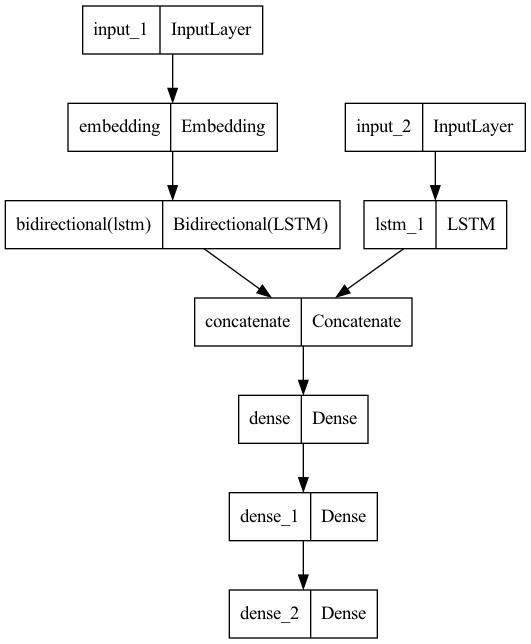

In [30]:
plot_model(model, to_file='model.png')


## XIII. Train the model

Using `BinaryCrossentropy` as the loss function and `BinaryAccuracy` as the metric for this binary classification problem, train the model over `N_EPOCHS` epochs. Since this is a multi-stage model, we use `model.train_on_batch` instead of `model.fit` for its flexibility. The `evaluate` function displays test (validation) metrics for each epoch.

The loss and accuracy for both train and test are displayed after training.

The model is expected to overfit to the training data, so if the optimal number of epochs determined by validation accuracy if found to be significantly different from the number of epochs used (or 0), then the model may be recompiled and retrained for only that many epochs.

The resulting loss and accuracy over the entire test set is displayed after training.


In [31]:
# define metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')


In [32]:
# function to evaluate on the validation (test) data
# this function is modified from HW3 of this course
def evaluate(max_steps=None):
    steps = 0
    for news_batch, stocks_batch, target_batch in test_ds:
        if max_steps != None and steps == max_steps:
            break
        if USE_NEWS_MODEL and not USE_STOCKS_MODEL:
            predictions = model.predict(x=[news_batch], verbose=0)
        elif USE_STOCKS_MODEL and not USE_NEWS_MODEL:
            predictions = model.predict(x=[stocks_batch], verbose=0)
        else:
            predictions = model.predict(x=[news_batch, stocks_batch], verbose=0)
        steps += 1 
        # Record metrics after each batch
        val_loss(target_batch, predictions)
        val_accuracy(target_batch, predictions)
        

In [33]:
# function to perform training loop
# this function is modified from HW3 of this course
def train_model(epochs=N_EPOCHS):
    # Used to track loss and accuracy as we go
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    
    # Training loop
    for epoch in range(epochs):

        start = time.time()

        # Train for one epoch
        for news_batch, stocks_batch, target_batch in train_ds:
            if USE_NEWS_MODEL and not USE_STOCKS_MODEL:
                result = model.train_on_batch(x=[news_batch], y=target_batch, reset_metrics=False)
            elif USE_STOCKS_MODEL and not USE_NEWS_MODEL:
                result = model.train_on_batch(x=[stocks_batch], y=target_batch, reset_metrics=False)
            else:
                result = model.train_on_batch(x=[news_batch, stocks_batch], y=target_batch, reset_metrics=False)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

        # Evaluate for a few steps
        evaluate()

        # Print progress
        print(template.format(epoch,
                            train_loss.result(),
                            train_accuracy.result() * 100,
                            val_loss.result(),
                            val_accuracy.result() * 100,
                            time.time() - start))

        # Record history
        train_loss_history.append(train_loss.result())
        train_acc_history.append(train_accuracy.result() * 100)
        val_loss_history.append(val_loss.result())
        val_acc_history.append(val_accuracy.result() * 100)

        # Reset the metrics for the next epoch"
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()
        
    # obtain metrics as history
    history = {'loss': train_loss_history,
           'accuracy': train_acc_history,
           'val_loss': val_loss_history,
           'val_accuracy': val_acc_history}
    return history
        

In [34]:
# function to plot loss and accuracy
def plot_loss_and_acc(history):
    train_loss = history['loss']
    train_acc = history['accuracy']
    try:
        val_loss = history['val_loss']
        val_acc = history['val_accuracy']
    except:
        pass
    n_epochs = range(len(train_loss))

    plt.figure(figsize=(10,4))
    
    # plot loss for each set
    plt.subplot(1,2,1)
    plt.plot(n_epochs, train_loss, label='train')
    try:
        plt.plot(n_epochs, val_loss, label='val')
        plt.title('Train and Validation Loss')
        plt.legend()
    except:
        plt.title('Train Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    # plot accuracy for each set
    plt.subplot(1,2,2)
    plt.plot(n_epochs, train_acc, label='train')
    try:
        plt.plot(n_epochs, val_acc, label='val')
        plt.title('Train and Validation Accuracy')
        plt.legend()
    except:
        plt.title('Train Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    
    plt.tight_layout(pad=1)
    plt.show()
    

In [35]:
history = train_model(epochs=N_EPOCHS)


Epoch 0, Loss: 0.69, Accuracy: 56.07, Val Loss 0.70, Val Accuracy 47.78, Time: 21.2 secs
Epoch 1, Loss: 0.69, Accuracy: 56.40, Val Loss 0.70, Val Accuracy 47.78, Time: 14.8 secs
Epoch 2, Loss: 0.68, Accuracy: 56.75, Val Loss 0.71, Val Accuracy 48.36, Time: 16.2 secs
Epoch 3, Loss: 0.68, Accuracy: 57.17, Val Loss 0.70, Val Accuracy 48.07, Time: 16.4 secs
Epoch 4, Loss: 0.67, Accuracy: 58.10, Val Loss 0.70, Val Accuracy 51.74, Time: 16.3 secs
Epoch 5, Loss: 0.66, Accuracy: 60.60, Val Loss 0.72, Val Accuracy 52.41, Time: 16.6 secs
Epoch 6, Loss: 0.63, Accuracy: 63.28, Val Loss 0.79, Val Accuracy 50.58, Time: 19.5 secs
Epoch 7, Loss: 0.60, Accuracy: 65.95, Val Loss 0.91, Val Accuracy 51.06, Time: 19.2 secs
Epoch 8, Loss: 0.57, Accuracy: 68.41, Val Loss 1.00, Val Accuracy 53.86, Time: 17.2 secs
Epoch 9, Loss: 0.54, Accuracy: 70.51, Val Loss 1.08, Val Accuracy 51.45, Time: 16.3 secs
Epoch 10, Loss: 0.51, Accuracy: 72.43, Val Loss 1.17, Val Accuracy 52.61, Time: 16.7 secs
Epoch 11, Loss: 0.49

Hyperparameters (2022-12-19):
	Num days in test: 7 (0.20%)
	Stock data downloaded: 2mo
	Num weeks in each sequence: 4
	Num timesteps: 3
	Dataet is balanced: True
	Retrict to one stock-url pair per day: False
	Stopwords removed: True
	Max seq len: 490
	Vocab size: 10000
	Model type: news and stocks
	News embedding dimension: 128
	Use Bidirectional for news: True
	News layer units: [16]
	News dropout: 0.2
	Stock layer units: [64]
	Stock dropout: 0.1
	Dense layer units: [32, 32, 1]
	Learning rate: 0.0001


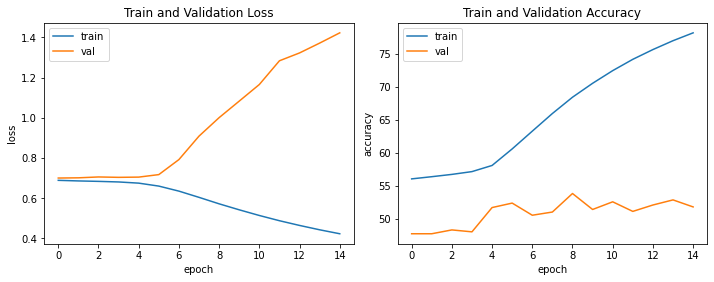

In [37]:
print(f'Hyperparameters ({date_today}):')
print(f'\tNum days in test: {N_DAYS_IN_TEST} ({test_percent:.2f}%)')
print(f'\tStock data downloaded: {N_STOCK_UNITS}{STOCK_UNIT}')
print(f'\tNum weeks in each sequence: {N_SEQ_WEEKS}')
print(f'\tNum timesteps: {N_TIMESTEPS}')     # N_SEQ_UNITS + 1
print(f'\tDataet is balanced: {BALANCE_DATASET}')
print(f'\tRetrict to one stock-url pair per day: {ONE_PER_DAY}')
print(f'\tStopwords removed: {REMOVE_STOPWORDS}')
print(f'\tMax seq len: {MAX_SEQ_LEN}')
print(f'\tVocab size: {VOCAB_SIZE}')
print(f'\tModel type:', end=' ')
if USE_NEWS_MODEL:
    print('news', end=' ')
    if USE_STOCKS_MODEL:
        print('and', end=' ')
if USE_STOCKS_MODEL:
    print('stocks')
print(f'\tNews embedding dimension: {NEWS_EMBEDDING_DIM}')
print(f'\tUse Bidirectional for news: {NEWS_USE_BIDIRECTIONAL}')
print(f'\tNews layer units: {NEWS_UNITS}')
print(f'\tNews dropout: {NEWS_DROPOUT}')
print(f'\tStock layer units: {STOCK_UNITS}')
print(f'\tStock dropout: {STOCK_DROPOUT}')
print(f'\tDense layer units: {DENSE_UNITS}')
print(f'\tLearning rate: {LR}')

plot_loss_and_acc(history)


In [38]:
# # uncomment to recompile and train for the optimal number of epochs (if different enough from 0 or 20) to avoid overfitting
# model = build_and_compile_model()
# n_epochs = np.argmax(history['val_accuracy'])
# if n_epochs >= 3 and n_epochs <= int(np.ceil(N_EPOCHS*0.75)):
#     print(f'Retrain for only {n_epochs} epochs...\n')
#     history = train_model(epochs=n_epochs)
    

In [39]:
# display the final metrics on the test set, also used for validation
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

for news_batch, stocks_batch, target_batch in test_ds:
    test_preds = model.predict(x=[news_batch, stocks_batch], verbose=0)
    test_loss(target_batch, test_preds)
    test_accuracy(target_batch, test_preds)
    
print(f'Test loss: {test_loss.result():.4f}')
print(f'Test accuracy: {test_accuracy.result()*100:.4f}')


Test loss: 1.4387
Test accuracy: 51.8340


## XIV. An alternate metric: take the average score of test predictions grouped by stock

It is important to note that most stocks appear in the test set more than once. Depending on the articles' publish dates and `N_DAYS_IN_TEST` used in the test set, test examples for the same stock likely share the same label and have overlapping (or identical) stock squences. Being aware of this is the first step to careful interpretation of the metrics.

Reducing the news data to avoid this commonality using `ONE_PER_DAY` would restrict the available data unneccesarily, and perhaps introduce bias when selecting or discarding certian articles. Thus we embrace the nature of the data, and introduce an additional metric: grouped by stock and publish date, take the average of the model outputs and round to 0 or 1 to predict whether the stock will decrease or increase respectively. This mirrors the way we use data inform decisions in the real world, consulting multiple sources for a concensus or average recommendation. This could be extended to include the predictions from previous days or weeks in a weighted average.

Note that this metric only gives additional insight if `ONE_PER_DAY = False`.

Using 0.5 as the rounding threshold is a hyperparameter than can be tuned. Again, the tie is broken arbitrarily in favor of increase (1).

In [40]:
verbose = 0
if not ONE_PER_DAY:
    threshes = [0.5]     # alternatively, try different thresholds with threshes = np.arange(0.1,1,0.1)
    test_stocks = np.unique(test_news_df['stock'])

    for thresh in threshes:
        matches = []
        for stock in test_stocks:
            stock_df = test_news_df[test_news_df['stock'] == stock]
            for day in np.unique(stock_df['publish_date']):
                day_df = stock_df[stock_df['publish_date'] == day].reset_index(drop=True)
                tmp_news = list(day_df['news'])
                tmp_news_vec = vectorize_layer(tmp_news).numpy()
                tmp_stocks = list(day_df['stock_seq'])
                tmp_targets = list(day_df['target'])
                tmp_ds = create_ds(tmp_news_vec, tmp_stocks, tmp_targets, N_TIMESTEPS)
                preds = []
                for news_batch, stocks_batch, target_batch in tmp_ds:
                    if USE_NEWS_MODEL and not USE_STOCKS_MODEL:
                        preds += list(model.predict(x=[news_batch], verbose=0))
                    elif USE_STOCKS_MODEL and not USE_NEWS_MODEL:
                        preds += list(model.predict(x=[stocks_batch], verbose=0))
                    else:
                        preds += list(model.predict(x=[news_batch, stocks_batch], verbose=0))

                raw_pred = np.mean(preds)
                if raw_pred < thresh:
                    pred = 0
                else:
                    pred = 1

                true = day_df.loc[0,'target']
                if verbose > 0:
                    preds_str = ' '.join([f'{p[0]:.2f}' for p in list(preds)])
                    print(f'stock: {stock}    preds: {preds_str}    avg pred: {pred} ({raw_pred:.2f})    true:{true}')

                if pred == true:
                    matches.append(1)
                else:
                    matches.append(0)

        if verbose > 0:
            print()
        print(f'Test accuracy (thresh={thresh}): {sum(matches)/len(matches):.4f}')
        if verbose > 0:
            print()
        

Test accuracy (thresh=0.5): 0.5244


## XV. Results, conclusion, and future improvements

The model achieves about **51.8%** (reaching 53.9% at its peak) test observation-wise accuracy with early stopping, and **52.4%** test accuracy when considering the average prediction grouped by stock and publish date.

Limitations and ideas for improvement are discussed throughout the notebook in the relevant sections. By exploring some of these options and continued experimentation with hyperparameter tuning and model selection, these results may see substantial improvements. A summary of the most significant future improvements is as follows:

- Acquire more news data over a longer period of time, ideally a few years.

- With a longer time frame of news observations, we will be able to afford contributing more time to the decrease (0) or increase (1) labels. Instead of next-day predictions, consider assigning the label based on the stock's value one week after the sequence considered, or perhaps on average after a period of time.

- Refine the selection of news articles using direct semantic analysis and relevance of the article to the stock (and vice versa).

- Use more data sources beyond Yahoo Finance, like the Financial Times or Harvard Business Review.

- Continue model selection and hyperparameter tuning to develop the best model for the updated dataset described above.

- Redefine the problem as regression instead of binary classification to predict the future stock value(s) of interest as opposed to a mere increase or decrease.
